In [1]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +           # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")            # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read()
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&rsquo;', "'")
                                   .replace('&lsquo;', "'")
                                   .replace('&rdquo;', '"')
                                   .replace('&ldquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
# Word Count
for book in hp:
    print('{:,} words in {}'.format(sum(len(hp[book][chapter][1].split()) for chapter in hp[book]), book))
print()    
print('{:,} total words in collection'.format(sum(len(hp[book][chapter][1].split())
                                                for book in hp
                                                for chapter in hp[book])))

79,210 words in Harry Potter and the Sorcerer's Stone
83,597 words in Harry Potter and the Chamber of Secrets
111,450 words in Harry Potter and the Prisoner of Azkaban
193,171 words in Harry Potter and the Goblet of Fire
250,386 words in Harry Potter and the Order of the Phoenix
169,059 words in Harry Potter and the Half-Blood Prince
193,622 words in Harry Potter and the Deathly Hallows

1,080,495 total words in collection


In [5]:
# Average word length
for book in hp:
    text = ''
    for chapter in hp[book]:
        text = text + hp[book][chapter][1]
    print('{:.2f} Average word length in {}'.format(len(text) / len(text.split()), book))

5.55 Average word length in Harry Potter and the Sorcerer's Stone
5.64 Average word length in Harry Potter and the Chamber of Secrets
5.65 Average word length in Harry Potter and the Prisoner of Azkaban
5.61 Average word length in Harry Potter and the Goblet of Fire
5.64 Average word length in Harry Potter and the Order of the Phoenix
5.66 Average word length in Harry Potter and the Half-Blood Prince
5.66 Average word length in Harry Potter and the Deathly Hallows


In [6]:
book = books[0][28:-4]
for chapter in hp[book]:
    print(hp[book][chapter][0])
    print(hp[book][chapter][1])
    print()

THE BOY WHO LIVED
Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere. The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn't think they could bear it if anyone found out about the Potters. Mrs. Potter was Mrs. Dursley's sister, but they hadn't met

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [8]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]
print(data[1])

Nearly ten years had passed since the Dursleys had woken up to find their nephew on the front step, but Privet Drive had hardly changed at all. The sun rose on the same tidy front gardens and lit up the brass number four on the Dursleys' front door; it crept into their living room, which was almost exactly the same as it had been on the night when Mr. Dursley had seen that fateful news report about the owls. Only the photographs on the mantelpiece really showed how much time had passed. Ten years ago, there had been lots of pictures of what looked like a large pink beach ball wearing different-colored bonnets — but Dudley Dursley was no longer a baby, and now the photographs showed a large blond boy riding his first bicycle, on a carousel at the fair, playing a computer game with his father, being hugged and kissed by his mother. The room held no sign at all that another boy lived in the house, too. Yet Harry Potter was still there, asleep at the moment, but not for long. His Aunt Petu

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 'hold', 'with', 'such', 'nonsense', 'mr', 'dursley', 'was', 'the', 'director', 'of', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'very', 'large', 'mustache', 'mrs', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning', 'over', 'garden', 'fences', 'spying', 'on', 'the', 'neighbors', 'the', 'dursleys', 'had', 'small', 'son', 'called', 'dudley', 'and', 'in', 'the

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['mr', 'and', 'mrs_dursley', 'of', 'number_four', 'privet_drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 'hold', 'with', 'such', 'nonsense', 'mr_dursley', 'was', 'the', 'director', 'of', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'very', 'large', 'mustache', 'mrs_dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning', 'over', 'garden', 'fences', 'spying', 'on', 'the', 'neighbors', 'the', 'dursleys', 'had', 'small', 'son', 'called', 'dudley', 'and', 'in', 'their', 'opinion', 

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['mr', 'mrs', 'dursley', 'number', 'four', 'privet_drive', 'proud', 'say', 'perfectly', 'normal', 'thank', 'much', 'last', 'people', 'expect', 'involve', 'anything', 'strange', 'mysterious', 'hold', 'nonsense', 'mr', 'dursley', 'director', 'firm', 'call', 'grunning', 'make', 'drill', 'big', 'beefy', 'man', 'hardly', 'neck', 'although', 'large', 'mustache', 'mrs', 'dursley', 'thin', 'blonde', 'nearly', 'twice', 'usual', 'amount', 'neck', 'come', 'useful', 'spend', 'much', 'time', 'crane', 'garden', 'fence', 'spy', 'neighbor', 'dursley', 'small', 'son', 'call', 'dudley', 'opinion', 'fine', 'boy', 'anywhere', 'dursley', 'everything', 'want', 'also', 'secret', 'great', 'fear', 'somebody', 'would', 'discover', 'think', 'could', 'bear', 'anyone', 'find', 'potter', 'mrs', 'potter', 'mrs', 'dursley', 'sister', 'meet', 'several', 'year', 'fact', 'mrs', 'dursley', 'pretend', 'sister', 'sister', 'good', 'nothing', 'husband', 'undursleyish', 'possible', 'dursley', 'shudder', 'think', 'neighbor', 

In [13]:
print(data_lemmatized[19])

['ron', 'breathe', 'harry', 'creep', 'window', 'pushing', 'could', 'talk', 'bar', 'ron', 'harry', 'mouth', 'fall', 'open', 'full', 'impact', 'see', 'hit', 'ron', 'lean', 'back', 'window', 'old', 'turquoise', 'car', 'park', 'midair', 'grin', 'harry', 'front', 'seat', 'fr', 'george', 'ron', 'eld', 'twin', 'brother', 'right', 'harry', 'ask', 'george', 'go', 'say', 'ron', 'answering', 'letter', 'ask', 'stay', 'twelve', 'time', 'dad', 'come', 'home', 'say', 'get', 'official', 'warning', 'use', 'magic', 'front', 'muggle', 'know', 'work', 'ministry', 'say', 'ron', 'know', 'suppose', 'spell', 'outside', 'school', 'talk', 'say', 'harry', 'star', 'float', 'car', 'oh', 'count', 'say', 'ron', 'borrow', 'dad', 'enchant', 'magic', 'front', 'muggle', 'live', 'tell', 'take', 'long', 'explain', 'look', 'tell', 'hogwart', 'dursley', 'lock', 'let', 'come', 'back', 'obviously', 'magic', 'ministry', 'think', 'second', 'spell', 'do', 'three', 'day', 'stop', 'gibber', 'say', 'ron', 'come', 'take', 'home', '-

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 3), (11, 2), (12, 5), (13, 2), (14, 2), (15, 2), (16, 1), (17, 1), (18, 2), (19, 1), (20, 3), (21, 1), (22, 1), (23, 2), (24, 5), (25, 1), (26, 1), (27, 2), (28, 1), (29, 3), (30, 1), (31, 10), (32, 3), (33, 3), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 4), (40, 2), (41, 15), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 3), (49, 2), (50, 3), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 3), (65, 2), (66, 1), (67, 1), (68, 2), (69, 2), (70, 4), (71, 2), (72, 5), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 3), (82, 1), (83, 1), (84, 1), (85, 1), (86, 9), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 2), (100, 1), (101, 4), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 9), (108, 1), (109, 3), (110, 

In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('-PRON-', 2),
  ('able', 2),
  ('across', 2),
  ('act', 2),
  ('admire', 1),
  ('affect', 1),
  ('afternoon', 1),
  ('age', 1),
  ('agree', 1),
  ('air', 3),
  ('albus', 3),
  ('allow', 2),
  ('almost', 5),
  ('also', 2),
  ('although', 2),
  ('always', 2),
  ('amount', 1),
  ('amuse', 1),
  ('angrily', 2),
  ('angry', 1),
  ('another', 3),
  ('answer', 1),
  ('anxious', 1),
  ('anyone', 2),
  ('anything', 5),
  ('anywhere', 1),
  ('apart', 1),
  ('appear', 2),
  ('approve', 1),
  ('arm', 3),
  ('armchair', 1),
  ('around', 10),
  ('arrive', 3),
  ('ask', 3),
  ('astonishing', 1),
  ('astounding', 1),
  ('astride', 1),
  ('aunt', 2),
  ('awake', 1),
  ('away', 4),
  ('baby', 2),
  ('back', 15),
  ('bag', 1),
  ('baker', 1),
  ('bakery', 1),
  ('ball', 1),
  ('bathroom', 1),
  ('beady', 1),
  ('bear', 3),
  ('beard', 2),
  ('bed', 3),
  ('bedroom', 1),
  ('beefy', 1),
  ('behave', 1),
  ('behavior', 1),
  ('behind', 1),
  ('believe', 3),
  ('belt', 1),
  ('bend', 1),
  ('beneath', 1)

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"xenophilius" + 0.026*"doge" + 0.024*"albus" + 0.020*"luna" + '
  '0.017*"ariana" + 0.017*"hallow" + 0.016*"deathly_hallow" + 0.015*"krum" + '
  '0.014*"mrs_cattermole" + 0.012*"auntie_muriel"'),
 (1,
  '0.037*"aunt_marge" + 0.010*"marge" + 0.008*"uncle_vernon" + 0.007*"petunia" '
  '+ 0.006*"ripper" + 0.006*"big_mistake" + 0.006*"drill" + 0.005*"brandy" + '
  '0.004*"dursley" + 0.004*"dog"'),
 (2,
  '0.038*"moody" + 0.031*"harry" + 0.024*"cedric" + 0.017*"champion" + '
  '0.012*"krum" + 0.011*"lockhart" + 0.011*"bagman" + 0.011*"go" + '
  '0.010*"karkaroff" + 0.010*"see"'),
 (3,
  '0.097*"dudley" + 0.097*"uncle_vernon" + 0.050*"aunt_petunia" + '
  '0.041*"dursley" + 0.027*"car" + 0.018*"harry" + 0.017*"letter" + '
  '0.010*"mrs_figg" + 0.008*"mirror" + 0.007*"uncle"'),
 (4,
  '0.000*"harry" + 0.000*"say" + 0.000*"ron" + 0.000*"go" + 0.000*"hermione" + '
  '0.000*"get" + 0.000*"see" + 0.000*"look" + 0.000*"back" + 0.000*"around"'),
 (5,
  '0.000*"harry" + 0.000*"say" + 0.

In [18]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -7.518687617579398
Coherence Score:  0.32272780527687117


In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(17,
  [('harry', 0.08043602983362019),
   ('door', 0.028456683878370626),
   ('open', 0.019736087205966726),
   ('neville', 0.01663798049340218),
   ('back', 0.014142283419391853),
   ('floor', 0.014027538726333907),
   ('room', 0.013855421686746987),
   ('head', 0.012908777969018933),
   ('wall', 0.01095811818703385),
   ('turn', 0.008519793459552496)]),
 (0,
  [('dumbledore', 0.04244648318042814),
   ('voldemort', 0.03310907237512742),
   ('harry', 0.028379204892966362),
   ('die', 0.010030581039755352),
   ('make', 0.009663608562691132),
   ('death', 0.009133537206931702),
   ('-PRON-', 0.008766564729867482),
   ('mother', 0.00835881753312946),
   ('great', 0.007951070336391437),
   ('understand', 0.0077879714576962284)]),
 (9,
  [('harry', 0.02640620398547168),
   ('malfoy', 0.02498282124276038),
   ('professor_mcgonagall', 0.020761755178168254),
   ('professor', 0.014381073917738295),
   ('student', 0.01222145872190046),
   ('filch', 0.012123294394816924),
   ('gryffindor', 0.01

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


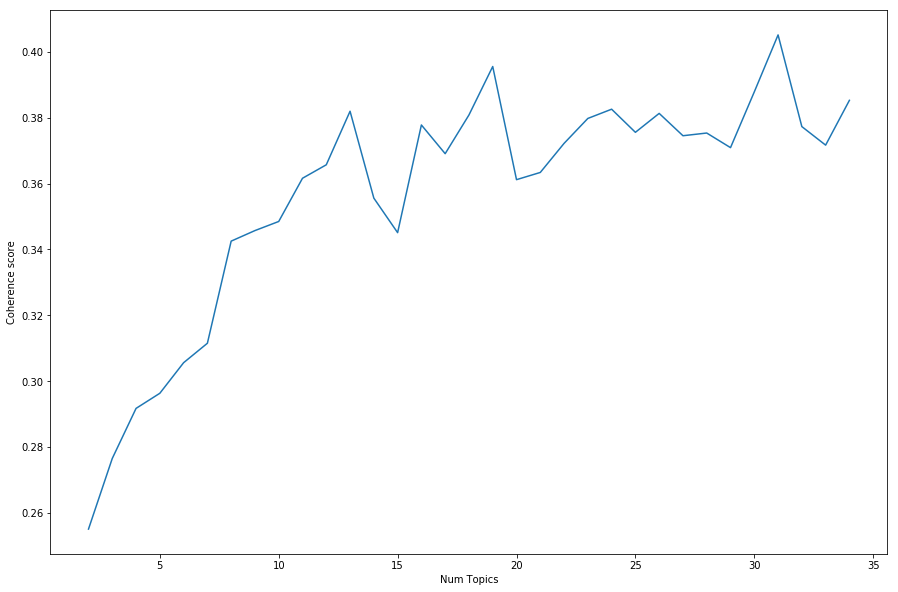

In [24]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.255005
Num Topics = 3  has Coherence Value of 0.276468
Num Topics = 4  has Coherence Value of 0.291681
Num Topics = 5  has Coherence Value of 0.296276
Num Topics = 6  has Coherence Value of 0.305564
Num Topics = 7  has Coherence Value of 0.311474
Num Topics = 8  has Coherence Value of 0.342506
Num Topics = 9  has Coherence Value of 0.345712
Num Topics = 10  has Coherence Value of 0.348479
Num Topics = 11  has Coherence Value of 0.361611
Num Topics = 12  has Coherence Value of 0.365703
Num Topics = 13  has Coherence Value of 0.381975
Num Topics = 14  has Coherence Value of 0.355573
Num Topics = 15  has Coherence Value of 0.345083
Num Topics = 16  has Coherence Value of 0.377801
Num Topics = 17  has Coherence Value of 0.369079
Num Topics = 18  has Coherence Value of 0.380839
Num Topics = 19  has Coherence Value of 0.395569
Num Topics = 20  has Coherence Value of 0.361184
Num Topics = 21  has Coherence Value of 0.363375
Num Topics = 22  has Coheren

In [26]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 10
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.022*"mrs_weasley" + 0.020*"mr_weasley" + 0.017*"fr" + 0.017*"ron" + '
  '0.015*"harry" + 0.014*"george" + 0.013*"door" + 0.012*"ministry" + '
  '0.011*"wizard" + 0.010*"fudge"'),
 (1,
  '0.056*"hermione" + 0.049*"ron" + 0.045*"harry" + 0.020*"wand" + '
  '0.011*"make" + 0.010*"goblin" + 0.010*"-PRON-" + 0.009*"luna" + '
  '0.008*"sword" + 0.007*"place"'),
 (2,
  '0.041*"hermione" + 0.035*"harry" + 0.018*"ron" + 0.012*"umbridge" + '
  '0.008*"give" + 0.007*"yeah" + 0.007*"back" + 0.007*"hand" + 0.007*"time" + '
  '0.007*"voice"'),
 (3,
  '0.084*"harry" + 0.015*"make" + 0.013*"slughorn" + 0.011*"ginny" + '
  '0.010*"time" + 0.010*"good" + 0.010*"kreacher" + 0.008*"find" + '
  '0.008*"room" + 0.008*"riddle"'),
 (4,
  '0.056*"harry" + 0.025*"ron" + 0.014*"hermione" + 0.013*"gryffindor" + '
  '0.012*"wood" + 0.011*"broom" + 0.011*"team" + 0.009*"good" + 0.009*"malfoy" '
  '+ 0.009*"play"'),
 (5,
  '0.060*"ron" + 0.026*"harry" + 0.020*"malfoy" + 0.013*"hermione" + '
  '0.012*"profe

In [27]:
optimal_model.show_topic(0,10)

[('mrs_weasley', 0.021520605202252237),
 ('mr_weasley', 0.019862516839959928),
 ('fr', 0.017306297281425957),
 ('ron', 0.0172717537738782),
 ('harry', 0.014646447200248713),
 ('george', 0.013955577049293585),
 ('door', 0.012677467270026598),
 ('ministry', 0.011641162043593906),
 ('wizard', 0.010604856817161215),
 ('fudge', 0.009948530173753843)]

In [28]:
for topic in sorted(optimal_model.show_topics(num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['mrs_weasley', 'mr_weasley', 'fr', 'ron', 'harry', 'george', 'door', 'ministry', 'wizard', 'fudge']
Topic 1: ['hermione', 'ron', 'harry', 'wand', 'make', 'goblin', '-PRON-', 'luna', 'sword', 'place']
Topic 2: ['hermione', 'harry', 'ron', 'umbridge', 'give', 'yeah', 'back', 'hand', 'time', 'voice']
Topic 4: ['harry', 'ron', 'hermione', 'gryffindor', 'wood', 'broom', 'team', 'good', 'malfoy', 'play']
Topic 5: ['ron', 'harry', 'malfoy', 'hermione', 'professor_mcgonagall', 'neville', 'professor', 'student', 'table', 'snape']
Topic 6: ['harry', 'moody', 'dobby', 'cedric', 'eye', 'krum', 'potter', 'make', 'back', 'sir']
Topic 7: ['harry', 'wand', 'back', 'hand', 'face', 'move', 'foot', 'light', 'head', 'feel']
Topic 8: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'letter', 'back', 'boy', 'owl', 'house', 'aunt_petunia']
Topic 9: ['hagrid', 'harry', 'hermione', 'yeh', 'ron', 'back', 'ter', '-PRON-', 'tree', 'forest']
Topic 11: ['harry', 'snape', 'sirius', 'lupin', 'black', 'demento

In [29]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.4635,"harry, uncle_vernon, dudley, dursley, letter, ...","Mr. and Mrs. Dursley, of number four, Privet D..."
1,1,8.0,0.6264,"harry, uncle_vernon, dudley, dursley, letter, ...",Nearly ten years had passed since the Dursleys...
2,2,8.0,0.5858,"harry, uncle_vernon, dudley, dursley, letter, ...",The escape of the Brazilian boa constrictor ea...
3,3,8.0,0.3815,"harry, uncle_vernon, dudley, dursley, letter, ...",BOOM. They knocked again. Dudley jerked awake....
4,4,8.0,0.3137,"harry, uncle_vernon, dudley, dursley, letter, ...",Harry woke early the next morning. Although he...
5,5,8.0,0.3859,"harry, uncle_vernon, dudley, dursley, letter, ...",Harry's last month with the Dursleys wasn't fu...
6,6,5.0,0.4740,"ron, harry, malfoy, hermione, professor_mcgona...","The door swung open at once. A tall, black-hai..."
7,7,5.0,0.3367,"ron, harry, malfoy, hermione, professor_mcgona...","There, look."" ""Where?"" ""Next to the tall kid w..."
8,8,5.0,0.3315,"ron, harry, malfoy, hermione, professor_mcgona...",Harry had never believed he would meet a boy h...
9,9,4.0,0.3397,"harry, ron, hermione, gryffindor, wood, broom,...",alfoy couldn't believe his eyes when he saw th...


In [30]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
19,19,0.0,0.3250,"mrs_weasley, mr_weasley, fr, ron, harry, georg...","Ron!"" breathed Harry, creeping to the window a..."
20,20,0.0,0.2574,"mrs_weasley, mr_weasley, fr, ron, harry, georg...",Life at the Burrow was as different as possibl...
36,36,0.0,0.3492,"mrs_weasley, mr_weasley, fr, ron, harry, georg...",Harry was several streets away before he colla...
37,37,0.0,0.2431,"mrs_weasley, mr_weasley, fr, ron, harry, georg...",It took Harry several days to get used to his ...
60,60,0.0,0.3841,"mrs_weasley, mr_weasley, fr, ron, harry, georg...",quo; WIZARD WHEEZES Harry spun faster and fast...
61,61,0.0,0.3571,"mrs_weasley, mr_weasley, fr, ron, harry, georg...",Harry felt as though he had barely lain down t...
62,62,0.0,0.2511,"mrs_weasley, mr_weasley, fr, ron, harry, georg...",Harry disentangled himself from Ron and got to...
65,65,0.0,0.2943,"mrs_weasley, mr_weasley, fr, ron, harry, georg...",Mr. Weasley woke them after only a few hours s...
66,66,0.0,0.2573,"mrs_weasley, mr_weasley, fr, ron, harry, georg...",There was a definite end-of-the-holidays gloom...
95,95,0.0,0.2803,"mrs_weasley, mr_weasley, fr, ron, harry, georg...","What's the Order of the — ?"" Harry began. ""Not..."


In [31]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'letter,',
  'back,',
  'boy,',
  'owl,',
  'house,',
  'aunt_petunia'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'letter,',
  'back,',
  'boy,',
  'owl,',
  'house,',
  'aunt_petunia'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'letter,',
  'back,',
  'boy,',
  'owl,',
  'house,',
  'aunt_petunia'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'letter,',
  'back,',
  'boy,',
  'owl,',
  'house,',
  'aunt_petunia'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'letter,',
  'back,',
  'boy,',
  'owl,',
  'house,',
  'aunt_petunia'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'letter,',
  'back,',
  'boy,',
  'owl,',
  'house,',
  'aunt_petunia'],
 ['ron,',
  'harry,',
  'malfoy,',
  'hermione,',
  'professor_mcgonagall,',
  'neville,',
  'professor,',
  'student,',
  'table,',
  'snape'],
 ['ron,',
  'harry,',
  'malfoy,',
  'hermione,',
  'prof

In [32]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'letter']
1. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'letter']
2. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'letter']
3. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'letter']
4. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'letter']
5. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'letter']
6. Dominant keywords: ['ron', 'harry', 'malfoy', 'hermione', 'professor_mcgonagall']
7. Dominant keywords: ['ron', 'harry', 'malfoy', 'hermione', 'professor_mcgonagall']
8. Dominant keywords: ['ron', 'harry', 'malfoy', 'hermione', 'professor_mcgonagall']
9. Dominant keywords: ['harry', 'ron', 'hermione', 'gryffindor', 'wood']
10. Dominant keywords: ['harry', 'ron', 'hermione', 'gryffindor', 'wood']
11. Dominant keywords: ['ron', 'harry', 'malfoy', 'hermione', 'professor_mcgonagall']
12. Dominant keywords: ['harry', 'ron'

In [33]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4491,"mrs_weasley, mr_weasley, fr, ron, harry, georg...",Harry awoke at half-past five the next morning...
1,1.0,0.4457,"hermione, ron, harry, wand, make, goblin, -PRO...",Harry turned to look at Ron and Hermione. Neit...
2,2.0,0.5497,"hermione, harry, ron, umbridge, give, yeah, ba...",They had expected to have to comb Hermione's D...
3,3.0,0.4333,"harry, make, slughorn, ginny, time, good, krea...",Harry could feel the Felix Felicis wearing off...
4,4.0,0.4804,"harry, ron, hermione, gryffindor, wood, broom,...","He — he sent me this,"" Hermione said, holding ..."
5,5.0,0.4740,"ron, harry, malfoy, hermione, professor_mcgona...","The door swung open at once. A tall, black-hai..."
6,6.0,0.3805,"harry, moody, dobby, cedric, eye, krum, potter...","Harry, Ron, and Hermione went up to the Owlery..."
7,7.0,0.7104,"harry, wand, back, hand, face, move, foot, lig...",Black shapes were emerging out of thin air all...
8,8.0,0.6264,"harry, uncle_vernon, dudley, dursley, letter, ...",Nearly ten years had passed since the Dursleys...
9,9.0,0.5947,"hagrid, harry, hermione, yeh, ron, back, ter, ...",quo;S TALE Harry sprinted up to the boys' dorm...


In [34]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: mrs_weasley, mr_weasley, fr, ron, harry, george, door, ministry, wizard, fudge

Harry awoke at half-past five the next morning as abruptly and completely as if somebody had yelled in his ear. For a few moments he lay immobile as the prospect of the hearing filled every tiny particle of his brain, then, unable to bear it, he leapt out of bed and put on his glasses. Mrs. Weasley had laid out his freshly laundered jeans and T-shirt at the foot of his bed. Harry scrambled into them. The blank picture on the wall sniggered again. Ron was lying sprawled on his back with his mouth wide open, fast asleep. He did not stir as Harry crossed the room, stepped out onto the landing, and closed the door softly behind him. Trying not to think of the next time he would see Ron, when they might no longer be fellow students at Hogwarts, Harry walked quietly down the stairs, past the heads of Kreacher's ancestors, and into the kitchen. He had expected it to be empty, but it was no

In [35]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"mrs_weasley, mr_weasley, fr, ron, harry, georg...",22,0.1146
1,1.0,"hermione, ron, harry, wand, make, goblin, -PRO...",14,0.0729
2,2.0,"hermione, harry, ron, umbridge, give, yeah, ba...",19,0.0990
3,3.0,"harry, make, slughorn, ginny, time, good, krea...",12,0.0625
4,4.0,"harry, ron, hermione, gryffindor, wood, broom,...",11,0.0573
5,5.0,"ron, harry, malfoy, hermione, professor_mcgona...",23,0.1198
6,6.0,"harry, moody, dobby, cedric, eye, krum, potter...",10,0.0521
7,7.0,"harry, wand, back, hand, face, move, foot, lig...",30,0.1562
8,8.0,"harry, uncle_vernon, dudley, dursley, letter, ...",18,0.0938
9,9.0,"hagrid, harry, hermione, yeh, ron, back, ter, ...",9,0.0469


In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"mrs_weasley, mr_weasley, fr, ron, harry, george, door, ministry, wizard, fudge",22,0.1146
1,1.0,"hermione, ron, harry, wand, make, goblin, -PRON-, luna, sword, place",14,0.0729
2,2.0,"hermione, harry, ron, umbridge, give, yeah, back, hand, time, voice",19,0.0990
3,3.0,"harry, make, slughorn, ginny, time, good, kreacher, find, room, riddle",12,0.0625
4,4.0,"harry, ron, hermione, gryffindor, wood, broom, team, good, malfoy, play",11,0.0573
5,5.0,"ron, harry, malfoy, hermione, professor_mcgonagall, neville, professor, student, table, snape",23,0.1198
6,6.0,"harry, moody, dobby, cedric, eye, krum, potter, make, back, sir",10,0.0521
7,7.0,"harry, wand, back, hand, face, move, foot, light, head, feel",30,0.1562
8,8.0,"harry, uncle_vernon, dudley, dursley, letter, back, boy, owl, house, aunt_petunia",18,0.0938
9,9.0,"hagrid, harry, hermione, yeh, ron, back, ter, -PRON-, tree, forest",9,0.0469


In [37]:
df_dominant_topics.to_csv('df_dominant_topics.csv', index=False)